该代码的正确性、效果、需要留待参考，也许是正确的。算法本身具有解决问题的能力。

# 导入函数库

In [ ]:
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
torch.set_default_dtype(torch.float64)

# sum树

In [ ]:
class sum_tree:
  def __init__(self, memory_size):
    self.memory_size = memory_size
    self.memory_node = np.zeros(memory_size*2 - 1)
    self.memory_data = np.zeros(memory_size, dtype=object)

    self.priority_upper = 1

    self.memory_pointer = 0
  
  def add(self, transaction, priority_value):
    self.memory_data[self.memory_pointer] = transaction
    self.memory_pointer += 1
    if self.memory_pointer >= self.memory_size:
      self.memory_pointer = 0
    
    memory_index = self.memory_size - 1 + self.memory_pointer
    self.update_index(priority_value, memory_index)
  
  def update_index(self, priority_value, memory_index):
    change_value = priority_value - self.memory_node[memory_index]
    self.memory_node[memory_index] = priority_value
    while memory_index!=0 :
      memory_index = (memory_index -1) // 2
      self.memory_node[memory_index] += change_value
  
  def get(self, priority_choose):
    node_start = 0
    # import pdb; pdb.set_trace()
    while True:
      node_left = node_start*2 + 1
      node_right = node_left + 1
      if node_left >= self.memory_size*2 -1:
        node_end = node_start
        break
      else:
        if priority_choose <= self.memory_node[node_left]:
          node_start = node_left
        else:
          priority_choose -= self.memory_node[node_left]
          node_start = node_right
    data_index = node_end - (self.memory_size - 1)
    return node_end, self.memory_node[node_end], self.memory_data[data_index]

  @property
  def priority_max(self):
    priority_value = np.max(self.memory_node[-self.memory_size:])
    if priority_value <= 0:
      priority_value = self.priority_upper
    return priority_value

  @property
  def priority_min(self):
    priority_value = np.min(self.memory_node[-self.memory_size:])
    return priority_value
  
  @property
  def priority_sum(self):
    return self.memory_node[0]


# 经验池

In [ ]:
class memory_priority:
  def __init__(self, env, memory_length=10000, memory_minibatch=32, alpha=0.6,
               beta=0.4, beta_increment=0.001):
    self.env = env
    self.memory_length = memory_length
    self.memory_minibatch = memory_minibatch
    self.alpha = alpha
    self.beta = beta
    self.beta_increment = beta_increment

    self.state_size = self.env.observation_space.shape[0]
    try:self.action_size = self.env.action_space.shape[0]
    except:self.action_size = 1
    self.memory_width = self.state_size * 2 + self.action_size + 1

    self.memory = sum_tree(self.memory_length)

  def store(self, state, action, reward, next_state):
    transacton = np.hstack((state, action, reward, next_state))
    priority_value = self.memory.priority_max
    self.memory.add(transacton, priority_value)

  # test_cnt = 0
  def sample(self):
    # import pdb; pdb.set_trace()
    priority_index_array = np.empty(self.memory_minibatch)
    memory_array = np.empty((self.memory_minibatch, self.memory_width))
    weight_array = np.empty(self.memory_minibatch)

    priority_segment = self.memory.priority_sum / self.memory_minibatch
    if self.beta < 1:
      self.beta += self.beta_increment
    priority_min = self.memory.priority_min / self.memory.priority_sum
    # self.test_cnt += 1
    # if self.test_cnt > 2000:
    #   import pdb; pdb.set_trace()
    for i in range(self.memory_minibatch):
      left, right = priority_segment*i, priority_segment*(i+1)
      priority_choose = np.random.uniform(left, right)
      priority_index, priority_value, memory_data = self.memory.get(priority_choose)
 
      weight = np.power(priority_value/priority_min, -self.beta)

      priority_index_array[i] = priority_index
      weight_array[i] = weight
      memory_array[i,:] = memory_data

    return priority_index_array, weight_array, memory_array

  def batch_update(self, priority_index, priority_value):
    priority_value = priority_value + 0.00001
    store_value = np.power(priority_value, self.alpha)
    for index, value in zip(priority_index, store_value):
      value = min(value, self.memory.priority_upper)
      index = int(index)
      self.memory.update_index(value, index)


# 神经网络

In [ ]:
class network_priority:
  def __init__(self, env, hidden_dimension=100, learning_rate=1e-2):
    self.env = env
    self.hidden_dimension = hidden_dimension
    self.learning_rate = learning_rate
    self.input_dimension = self.env.observation_space.shape[0]
    self.output_dimension = self.env.action_space.n
    
    self.model = self.__create_network()
    self.loss_mse = self.loss_mse_custom
    self.loss_true = torch.nn.MSELoss()
    self.loss_l1 = torch.nn.L1Loss()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
  
  @staticmethod
  def replace(network_from, network_to):
    network_to.load_state_dict(network_from.state_dict())
  
  @staticmethod
  def optimizer(predict_object, predict_value, target_value, weight):
    loss = predict_object.loss_mse(predict_value, target_value, weight)
    predict_object.optimizer.zero_grad()
    loss.backward()
    predict_object.optimizer.step()

    loss_true = predict_object.loss_true(predict_value, target_value)
    return loss_true.item()
  # test_cnt = 0
  def loss_mse_custom(self, tensor1, tensor2, weight):
    # self.test_cnt += 1
    # if self.test_cnt > 100:
    #   import pdb; pdb.set_trace()
    # loss_value = torch.mean( torch.pow((tensor1-tensor2),2) * weight)
    loss_value = torch.sum( torch.pow((tensor1-tensor2),2) * weight)
    # loss_value = torch.ones_like(loss)
    return loss_value
    
  
  def __call__(self, state):
    action_value = self.model(state)
    return action_value

  def __create_network(self):
    return torch.nn.Sequential(torch.nn.Linear(self.input_dimension,self.hidden_dimension),
                            torch.nn.ReLU(),
                            torch.nn.Linear(self.hidden_dimension,self.output_dimension))

# 智能体

In [ ]:
class agent_priority_double_q:
  def __init__(self, env, epislon_method=1, gamma=0.99):
    self.env = env
    self.epislon_method = epislon_method
    self.gamma = gamma

    if self.epislon_method == 1:
      self.epislon_method =self.epislon_method_1()

    self.q_network = network_priority(self.env)
    self.q_network_target = network_priority(self.env)
    self.memory = memory_priority(self.env)


  def output_action(self, state):
    state = torch.from_numpy(state)
    action_value = self.q_network(state)
    action_value = np.array(action_value.tolist())

    random_number = np.random.random()
    if random_number > self.epislon_method.epislon_init:
      action = self.env.action_space.sample()
    else:
      action = np.argmax(action_value)
      action = np.squeeze(action)
    return action, action_value

  def sample_postprocess(self):
    weight_index, weight, memory_data = self.memory.sample()
    state, action, reward, next_state = self.sample_decouple(memory_data)

    state = torch.from_numpy(state)
    next_state = torch.from_numpy(next_state)
    action = np.squeeze(action)
    reward = np.squeeze(reward)
    action = action.astype(np.int32)
    return state, action, reward, next_state, weight, weight_index
  
  def sample_decouple(self, choice_data):
    state = choice_data[:,0:self.memory.state_size]
    action = choice_data[:,self.memory.state_size:self.memory.state_size+self.memory.action_size]
    reward = choice_data[:,self.memory.state_size+self.memory.action_size:
                         self.memory.state_size+self.memory.action_size+1]
    next_state = choice_data[:,self.memory.state_size+self.memory.action_size+1:]
    return state, action, reward, next_state
  
  # test_cnt = 0
  def learn(self):
    state, action, reward, next_state, weight, weight_index = self.sample_postprocess()

    _ , action_max = torch.max(self.q_network.model(next_state), axis=1)
    target_value = self.q_network_target.model(next_state)
    target_value = np.array(target_value.tolist())
    replace_index = np.arange(self.memory.memory_minibatch, dtype=np.int32)
    target_value = target_value[replace_index, action_max]

    target_value = reward + self.gamma*np.array(target_value.tolist())

    predict_value_all = self.q_network.model(state)
    predict_value = predict_value_all[replace_index,action]

    td_error = target_value - np.array(predict_value.tolist())
    priority_value = np.abs(td_error)
    self.memory.batch_update(weight_index, priority_value)

    replace_index = np.arange(self.memory.memory_minibatch, dtype=np.int32)
    target_value_all = np.array(predict_value_all.tolist())
    target_value_all[replace_index,action] = target_value

    self.epislon_method.update()

    weight = torch.tensor(weight[:,np.newaxis])
    # self.test_cnt += 1
    # if self.test_cnt > 100:
    #   import pdb; pdb.set_trace()

    return network_priority.optimizer(self.q_network, predict_value_all,
                            torch.from_numpy(target_value_all), weight)

  class epislon_method_1:
    def __init__(self):
      self.epislon_init = 0.01
      self.epislon_increment = 1.001
      self.epislon_max = 0.9
    def update(self):
      if self.epislon_init < self.epislon_max:
        self.epislon_init *= self.epislon_increment
  
  class epislon_method_2:
    def __init__(self):
      self.epislon_init = 0.9
    def update(self):
      pass

# 交互

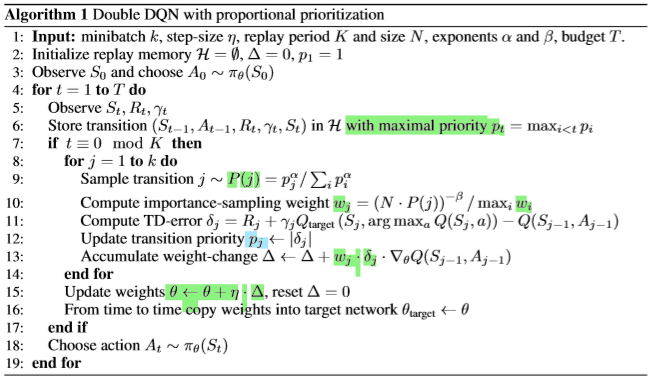

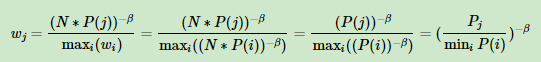

In [ ]:
class interactive_priority_double_q:
  def __init__(self, env_name='CartPole-v0', epoch_max=1000, epoch_replace=10):
    self.env_name = env_name
    self.epoch_max = epoch_max
    self.epoch_replace = epoch_replace

    self.env = gym.make(self.env_name)
    # if self.env_name == 'CartPole-v0':
    self.env = self.env.unwrapped
    self.agent = agent_priority_double_q(self.env)

  def reward_normalize(self, next_state):
    x, x_dot, theta, theta_dot = next_state
    r1 = (self.env.x_threshold - abs(x))/self.env.x_threshold - 0.8
    r2 = (self.env.theta_threshold_radians - abs(theta))/self.env.theta_threshold_radians - 0.5
    reward = r1 + r2
    return reward
  
  def start_execute(self):
    self.epoch_index = 0
    self.epoch_step_all = 0
    self.loss_value = 0
    for i in range(self.epoch_max):
      self.epoch_index += 1
      state = self.env.reset()
      self.epoch_step = 0
      self.statistic_reward = 0
      while True:
        self.epoch_step += 1
        self.epoch_step_all += 1
        action, _ = self.agent.output_action(state)
        next_state, reward, done, info = self.env.step(action)
        if self.env_name == 'CartPole-v0':
          reward = self.reward_normalize(next_state)
        if self.env_name == 'MountainCar-v0' and done:
          reward = 10
        self.agent.memory.store(state, action, reward, next_state)
        state = next_state
        self.statistic_reward += reward

        if self.epoch_step_all > self.agent.memory.memory_length:
          self.loss_value = self.agent.learn()
        if done:
          break
        if self.env_name == 'CartPole-v0' and self.epoch_step>1000:
          break
        
      if self.epoch_index % self.epoch_replace == 0:
        network_priority.replace(self.agent.q_network.model, 
                        self.agent.q_network_target.model)
      self.statistic()

  def statistic(self):
    if not self.epoch_index > 1:
      self.epoch_step_list = []
      self.loss_value_list = []
    
    print('epoch %-5s, length %-5s, reward %-5s, loss_value %10s, epislon %5f'%
          (self.epoch_index, self.epoch_step, self.statistic_reward, 
            self.loss_value, self.agent.epislon_method.epislon_init))
    self.epoch_step_list.append(self.epoch_step)
    self.loss_value_list.append(self.loss_value)

In [ ]:
priority_double_dqn_evoluate = interactive_priority_double_q(env_name='MountainCar-v0',epoch_max=20, epoch_replace=1)
priority_double_dqn_evoluate.start_execute()

epoch 1    , length 18345, reward -18334.0, loss_value 0.018629034558729832, epislon 0.900847
epoch 2    , length 440  , reward -429.0, loss_value 0.012911567693701028, epislon 0.900847
epoch 3    , length 601  , reward -590.0, loss_value 0.05014165644401521, epislon 0.900847
epoch 4    , length 1130 , reward -1119.0, loss_value 0.02406957294335131, epislon 0.900847
epoch 5    , length 655  , reward -644.0, loss_value 1.2676881305500485, epislon 0.900847
epoch 6    , length 557  , reward -546.0, loss_value 0.006068301397115686, epislon 0.900847
epoch 7    , length 961  , reward -950.0, loss_value 0.022909885922112582, epislon 0.900847
epoch 8    , length 746  , reward -735.0, loss_value 0.15626809645109774, epislon 0.900847
epoch 9    , length 917  , reward -906.0, loss_value 0.03359247275688249, epislon 0.900847
epoch 10   , length 720  , reward -709.0, loss_value 0.014192528447961676, epislon 0.900847
epoch 11   , length 585  , reward -574.0, loss_value 0.02092275799866483, epislon 0

In [ ]:
%debug

> /usr/lib/python3.7/bdb.py(113)dispatch_line()
    111         if self.stop_here(frame) or self.break_here(frame):
    112             self.user_line(frame)
--> 113             if self.quitting: raise BdbQuit
    114         return self.trace_dispatch
    115 

ipdb> q


# 深度Q对比

In [ ]:
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

In [ ]:
class memory:
  def __init__(self, env, memory_length=10000, memory_minibatch=32):
    self.env = env
    self.memory_length = memory_length
    self.memory_minibatch = memory_minibatch

    self.state_size = self.env.observation_space.shape[0]
    try:self.action_size = self.env.action_space.shape[0]
    except:self.action_size = 1
    
    self.memory_width = self.state_size * 2 + self.action_size + 1
    self.memory = np.zeros((self.memory_length, self.memory_width))

    self.index = 0
    self.max_index = 0

  def store(self, state, action, reward, next_state):
    transacton = np.hstack((state, action, reward, next_state))
    self.memory[self.index,:] = transacton

    self.index += 1
    if self.index % self.memory_length == 0:
      self.index = 0
    if self.max_index < self.memory_length:
      self.max_index += 1
  
  def sample(self):
    choice_random = np.random.choice(self.max_index, self.memory_minibatch)
    choice_data = self.memory[choice_random,:]
    state = choice_data[:,0:self.state_size]
    action = choice_data[:,self.state_size:self.state_size+self.action_size]
    reward = choice_data[:,self.state_size+self.action_size:
                         self.state_size+self.action_size+1]
    next_state = choice_data[:,self.state_size+self.action_size+1:]

    reward = np.squeeze(reward)
    if self.action_size == 1:
      action = np.squeeze(action)
    return state, action, reward, next_state
class network:
  def __init__(self, env, hidden_dimension=100, learning_rate=1e-3):
    self.env = env
    self.hidden_dimension = hidden_dimension
    self.learning_rate = learning_rate

    self.input_dimension = self.env.observation_space.shape[0]
    self.output_dimension = self.env.action_space.n
    
    self.model = self.__create_network()
    self.loss = torch.nn.MSELoss()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
  
  @staticmethod
  def replace(network_from, network_to):
    network_to.load_state_dict(network_from.state_dict())

  @staticmethod
  def optimizer(predict_object, predict_value, target_value):
    loss = predict_object.loss(predict_value, target_value)
    predict_object.optimizer.zero_grad()
    loss.backward()
    predict_object.optimizer.step()
    return loss.item()
  
  def __call__(self, state):
    action_value = self.model(state)
    return action_value

  def __create_network(self):
    return torch.nn.Sequential(torch.nn.Linear(self.input_dimension,self.hidden_dimension),
                            torch.nn.ReLU(),
                            torch.nn.Linear(self.hidden_dimension,self.output_dimension))
class agent_q:
  def __init__(self, env, epislon_method=1, gamma=0.99):
    self.env = env
    self.epislon_method = epislon_method
    self.gamma = gamma

    if self.epislon_method == 1:
      self.epislon_method =self.epislon_method_1()
    
    self.q_network = network(self.env)
    self.q_network_target = network(self.env)
    self.memory = memory(self.env)

    pass

  def output_action(self, state):
    state = torch.from_numpy(state)
    action_value = self.q_network(state)
    action_value = np.array(action_value.tolist())

    random_number = np.random.random()
    if random_number > self.epislon_method.epislon_init:
      action = self.env.action_space.sample()
    else:
      action = np.argmax(action_value)
      action = np.squeeze(action)
    return action, action_value
  
  def sample_postprocess(self):
    state, action, reward, next_state = self.memory.sample()
    state = torch.from_numpy(state)
    next_state = torch.from_numpy(next_state)
    action = np.squeeze(action)
    reward = np.squeeze(reward)
    action = action.astype(np.int32)
    return state, action, reward, next_state
  
  def learn(self):
    state, action, reward, next_state = self.sample_postprocess()
    target_value_max, target_action_max = torch.max(self.q_network_target.model(next_state), axis=1)
    target_value = reward + self.gamma*np.array(target_value_max.tolist())

    predict_value_all = self.q_network.model(state)

    replace_index = np.arange(self.memory.memory_minibatch, dtype=np.int32)
    target_value_all = np.array(predict_value_all.tolist())
    target_value_all[replace_index,action] = target_value

    self.epislon_method.update()

    return network.optimizer(self.q_network, predict_value_all,
                      torch.from_numpy(target_value_all))

  class epislon_method_1:
    def __init__(self):
      self.epislon_init = 0.01
      self.epislon_increment = 1.001
      self.epislon_max = 0.9
    def update(self):
      if self.epislon_init < self.epislon_max:
        self.epislon_init *= self.epislon_increment
  
  class epislon_method_2:
    def __init__(self):
      self.epislon_init = 0.9
    def update(self):
      pass

class interactive:
  def __init__(self, env_name='CartPole-v0', epoch_max=1000, epoch_replace=10):
    self.env_name = env_name
    self.epoch_max = epoch_max
    self.epoch_replace = epoch_replace

    self.env = gym.make(self.env_name)
    self.env = self.env.unwrapped
    self.agent = agent_q(self.env)
  
  def start_execute(self):
    self.epoch_index = 0
    self.loss_value = 0
    for i in range(self.epoch_max):
      self.epoch_index += 1
      state = self.env.reset()
      self.epoch_step = 0
      self.statistic_reward = 0
      while True:
        self.epoch_step += 1
        action, _ = self.agent.output_action(state)
        next_state, reward, done, info = self.env.step(action)
        if done:
          reward = 10
        # reward = self.reward_normalize(next_state)
        self.agent.memory.store(state, action, reward, next_state)
        state = next_state
        self.statistic_reward += reward

        if self.epoch_index > 1:
          self.loss_value = self.agent.learn()
        if done :
          break
        
      if self.epoch_index % self.epoch_replace == 0:
        network.replace(self.agent.q_network.model, 
                        self.agent.q_network_target.model)
      self.statistic()

  def statistic(self):
    if not self.epoch_index > 1:
      self.epoch_step_list = []
      self.loss_value_list = []
    
    print('epoch %-5s, length %-5s, reward %-5s, loss_value %10f, epislon %5f'%
          (self.epoch_index, self.epoch_step, self.statistic_reward, 
            self.loss_value, self.agent.epislon_method.epislon_init))
    self.epoch_step_list.append(self.epoch_step)
    self.loss_value_list.append(self.loss_value)

# 深度Q执行

In [ ]:
dqn_evoluate = interactive(env_name='MountainCar-v0',epoch_max=20, epoch_replace=1)
dqn_evoluate.start_execute()

epoch 1    , length 25330, reward -25319.0, loss_value   0.000000, epislon 0.010000
epoch 2    , length 6323 , reward -6312.0, loss_value   0.001123, epislon 0.900847
epoch 3    , length 638  , reward -627.0, loss_value   0.000059, epislon 0.900847
epoch 4    , length 607  , reward -596.0, loss_value   0.000247, epislon 0.900847
epoch 5    , length 901  , reward -890.0, loss_value   0.000203, epislon 0.900847
epoch 6    , length 238  , reward -227.0, loss_value   0.003689, epislon 0.900847
epoch 7    , length 600  , reward -589.0, loss_value   0.000762, epislon 0.900847
epoch 8    , length 834  , reward -823.0, loss_value   0.001285, epislon 0.900847
epoch 9    , length 618  , reward -607.0, loss_value   0.000702, epislon 0.900847
epoch 10   , length 1132 , reward -1121.0, loss_value   0.000801, epislon 0.900847
epoch 11   , length 1008 , reward -997.0, loss_value   0.004151, epislon 0.900847
epoch 12   , length 1173 , reward -1162.0, loss_value   0.000178, epislon 0.900847
epoch 13   

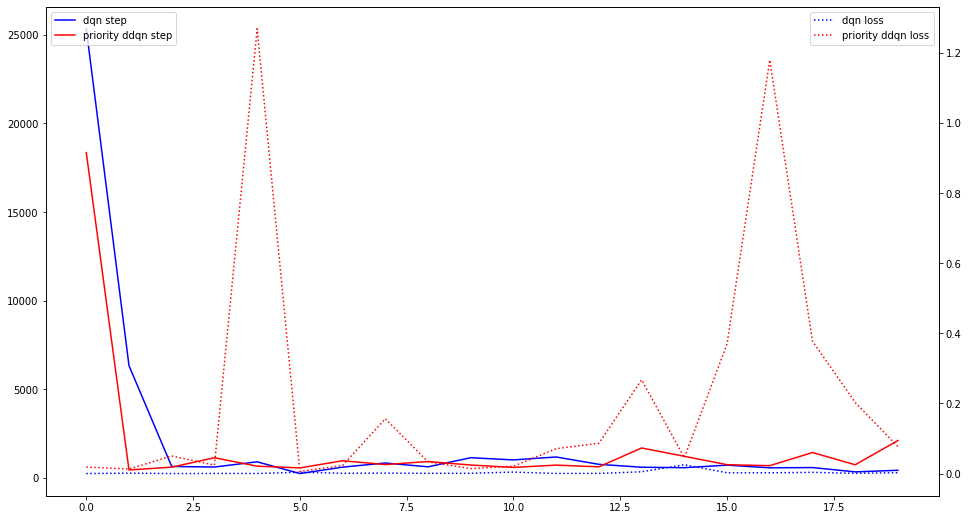

In [ ]:
figure = plt.figure(figsize=(16,9))
ax1 = figure.add_subplot(111)
ax1.plot(dqn_evoluate.epoch_step_list,c='b')
ax1.plot(priority_double_dqn_evoluate.epoch_step_list,c='r')
plt.legend(['dqn step','priority ddqn step'], loc='upper left')
ax2 = ax1.twinx()
ax2.plot(dqn_evoluate.loss_value_list,c='b',linestyle=':')
ax2.plot(priority_double_dqn_evoluate.loss_value_list,c='r',linestyle=':')
plt.legend(['dqn loss','priority ddqn loss'], loc='upper right')
plt.show()

# 工具结尾

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
tf.reset_default_graph()
import gym
import matplotlib.pyplot as plt

np.random.seed(1)
tf.set_random_seed(1)


class SumTree(object):
    data_pointer = 0
    def __init__(self, capacity):
        self.capacity = capacity  # for all priority values
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)  # for all transitions
    def add(self, p, data):
        tree_idx = self.data_pointer + self.capacity - 1
        self.data[self.data_pointer] = data  # update data_frame
        self.update(tree_idx, p)  # update tree_frame
        self.data_pointer += 1
        if self.data_pointer >= self.capacity:  # replace when exceed the capacity
            self.data_pointer = 0
    def update(self, tree_idx, p):
        change = p - self.tree[tree_idx]
        self.tree[tree_idx] = p
        while tree_idx != 0:    # this method is faster than the recursive loop in the reference code
            tree_idx = (tree_idx - 1) // 2
            self.tree[tree_idx] += change
    def get_leaf(self, v):
        parent_idx = 0
        while True:    
            cl_idx = 2 * parent_idx + 1        
            cr_idx = cl_idx + 1
            if cl_idx >= len(self.tree):  
                # import pdb; pdb.set_trace()    
                leaf_idx = parent_idx
                break
            else:      
                if v <= self.tree[cl_idx]:
                    parent_idx = cl_idx
                else:
                    v -= self.tree[cl_idx]
                    parent_idx = cr_idx

        data_idx = leaf_idx - self.capacity + 1
        return leaf_idx, self.tree[leaf_idx], self.data[data_idx]

    @property
    def total_p(self):
        return self.tree[0]  # the root

class Memory(object):  # stored as ( s, a, r, s_ ) in SumTree

    epsilon = 0.01  # small amount to avoid zero priority
    alpha = 0.6  # [0~1] convert the importance of TD error to priority
    beta = 0.4  # importance-sampling, from initial value increasing to 1
    beta_increment_per_sampling = 0.001
    abs_err_upper = 1.  # clipped abs error

    def __init__(self, capacity):
        self.tree = SumTree(capacity)

    def store(self, transition):
        max_p = np.max(self.tree.tree[-self.tree.capacity:])
        if max_p == 0:
            max_p = self.abs_err_upper
        self.tree.add(max_p, transition)   # set the max p for new p
    # test_cnt = 0
    def sample(self, n):
        b_idx, b_memory, ISWeights = np.empty((n,), dtype=np.int32), np.empty((n, self.tree.data[0].size)), np.empty((n, 1))
        pri_seg = self.tree.total_p / n       # priority segment
        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])  # max = 1

        min_prob = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total_p     # for later calculate ISweight
        # self.test_cnt += 1
        # if self.test_cnt > 100:
        #   import pdb; pdb.set_trace()
        for i in range(n):
            a, b = pri_seg * i, pri_seg * (i + 1)
            v = np.random.uniform(a, b)
            idx, p, data = self.tree.get_leaf(v)
            prob = p / self.tree.total_p
            ISWeights[i, 0] = np.power(prob/min_prob, -self.beta)
            b_idx[i], b_memory[i, :] = idx, data
        return b_idx, b_memory, ISWeights

    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.epsilon  # convert to abs and avoid 0
        clipped_errors = np.minimum(abs_errors, self.abs_err_upper)
        ps = np.power(clipped_errors, self.alpha)
        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)


class DQNPrioritizedReplay:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.005,
            reward_decay=0.9,
            e_greedy=0.9,
            replace_target_iter=500,
            memory_size=10000,
            batch_size=32,
            e_greedy_increment=None,
            output_graph=False,
            prioritized=True,
            sess=None,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        self.prioritized = prioritized    # decide to use double q or not

        self.learn_step_counter = 0

        self._build_net()
        t_params = tf.get_collection('target_net_params')
        e_params = tf.get_collection('eval_net_params')
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        if self.prioritized:
            self.memory = Memory(capacity=memory_size)
        else:
            self.memory = np.zeros((self.memory_size, n_features*2+2))

        if sess is None:
            self.sess = tf.Session()
            self.sess.run(tf.global_variables_initializer())
        else:
            self.sess = sess

        if output_graph:
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.cost_his = []

    def _build_net(self):
        def build_layers(s, c_names, n_l1, w_initializer, b_initializer, trainable):
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names, trainable=trainable)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names,  trainable=trainable)
                l1 = tf.nn.relu(tf.matmul(s, w1) + b1)

            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names,  trainable=trainable)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names,  trainable=trainable)
                out = tf.matmul(l1, w2) + b2
            return out

        # ------------------ build evaluate_net ------------------
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input
        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name='Q_target')  # for calculating loss
        if self.prioritized:
            self.ISWeights = tf.placeholder(tf.float32, [None, 1], name='IS_weights')
        with tf.variable_scope('eval_net'):
            c_names, n_l1, w_initializer, b_initializer = \
                ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 20, \
                tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)  # config of layers

            self.q_eval = build_layers(self.s, c_names, n_l1, w_initializer, b_initializer, True)

        with tf.variable_scope('loss'):
            if self.prioritized:
                self.abs_errors = tf.reduce_sum(tf.abs(self.q_target - self.q_eval), axis=1)    # for updating Sumtree
                self.loss = tf.reduce_mean(self.ISWeights * tf.squared_difference(self.q_target, self.q_eval))
            else:
                self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        with tf.variable_scope('train'):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

        # ------------------ build target_net ------------------
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')    # input
        with tf.variable_scope('target_net'):
            c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]
            self.q_next = build_layers(self.s_, c_names, n_l1, w_initializer, b_initializer, False)

    def store_transition(self, s, a, r, s_):
        if self.prioritized:    # prioritized replay
            transition = np.hstack((s, [a, r], s_))
            self.memory.store(transition)    # have high priority for newly arrived transition
        else:       # random replay
            if not hasattr(self, 'memory_counter'):
                self.memory_counter = 0
            transition = np.hstack((s, [a, r], s_))
            index = self.memory_counter % self.memory_size
            self.memory[index, :] = transition
            self.memory_counter += 1

    def choose_action(self, observation):
        observation = observation[np.newaxis, :]
        if np.random.uniform() < self.epsilon:
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.replace_target_op)
            # print('\ntarget_params_replaced\n')
        if self.prioritized:
            tree_idx, batch_memory, ISWeights = self.memory.sample(self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
            batch_memory = self.memory[sample_index, :]

        q_next, q_eval = self.sess.run(
                [self.q_next, self.q_eval],
                feed_dict={self.s_: batch_memory[:, -self.n_features:],
                           self.s: batch_memory[:, :self.n_features]})
        q_target = q_eval.copy()
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        eval_act_index = batch_memory[:, self.n_features].astype(int)
        reward = batch_memory[:, self.n_features + 1]

        q_target[batch_index, eval_act_index] = reward + self.gamma * np.max(q_next, axis=1)

        if self.prioritized:
            _, abs_errors, self.cost = self.sess.run([self._train_op , self.abs_errors, self.loss],
                                         feed_dict={self.s: batch_memory[:, :self.n_features],
                                                    self.q_target: q_target,
                                                    self.ISWeights: ISWeights})
            # print(batch_memory)
            self.memory.batch_update(tree_idx, abs_errors)     # update priority
        else:
            _, self.cost = self.sess.run([self._train_op, self.loss],
                                         feed_dict={self.s: batch_memory[:, :self.n_features],
                                                    self.q_target: q_target})

        self.cost_his.append(self.cost)

        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1




env = gym.make('MountainCar-v0')
env = env.unwrapped

MEMORY_SIZE = 10000#10000

sess = tf.Session()
with tf.variable_scope('natural_DQN'):
    RL_natural = DQNPrioritizedReplay(
        n_actions=3, n_features=2, memory_size=MEMORY_SIZE,
        e_greedy_increment=0.00005, sess=sess, prioritized=False,
    )

with tf.variable_scope('DQN_with_prioritized_replay'):
    RL_prio = DQNPrioritizedReplay(
        n_actions=3, n_features=2, memory_size=MEMORY_SIZE,
        e_greedy_increment=0.00005, sess=sess, prioritized=True, output_graph=True,
    )
sess.run(tf.global_variables_initializer())


def train(RL):
    total_steps = 0
    steps = []
    episodes = []
    for i_episode in range(20):
        observation = env.reset()
        while True:
            
            action = RL.choose_action(observation)
            observation_, reward, done, info = env.step(action)

            if done: reward = 10
            RL.store_transition(observation, action, reward, observation_)

            if total_steps > MEMORY_SIZE:
                RL.learn()
            # if i_episode > 1:
            #     env.render()
            if done:
                print('episode ', i_episode, ' finished')
                steps.append(total_steps)
                episodes.append(i_episode)
                break

            observation = observation_
            total_steps += 1
    return np.vstack((episodes, steps))

# his_natural = train(RL_natural)
his_prio = train(RL_prio)

# compare based on first success
# plt.plot(his_natural[0, :], his_natural[1, :] - his_natural[1, 0], c='b', label='natural DQN')
plt.plot(his_prio[0, :], his_prio[1, :] - his_prio[1, 0], c='r', label='DQN with prioritized replay')
plt.legend(loc='best')
plt.ylabel('total training time')
plt.xlabel('episode')
plt.grid()
plt.show()

> <ipython-input-2-98de2d11c2e6>(81)sample()
-> for i in range(n):
(Pdb) l
 76  	
 77  	        min_prob = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total_p     # for later calculate ISweight
 78  	        self.test_cnt += 1
 79  	        if self.test_cnt > 100:
 80  	          import pdb; pdb.set_trace()
 81  ->	        for i in range(n):
 82  	            a, b = pri_seg * i, pri_seg * (i + 1)
 83  	            v = np.random.uniform(a, b)
 84  	            idx, p, data = self.tree.get_leaf(v)
 85  	            prob = p / self.tree.total_p
 86  	            ISWeights[i, 0] = np.power(prob/min_prob, -self.beta)
(Pdb) b 88
Breakpoint 4 at <ipython-input-2-98de2d11c2e6>:88
(Pdb) r
> <ipython-input-2-98de2d11c2e6>(88)sample()
-> return b_idx, b_memory, ISWeights
(Pdb) ISWeights
array([[0.25277551],
       [0.25277551],
       [0.25277551],
       [0.25277551],
       [0.25277551],
       [0.25277551],
       [0.33383333],
       [0.27617411],
       [0.25277551],
       [0.4

BdbQuit: ignored

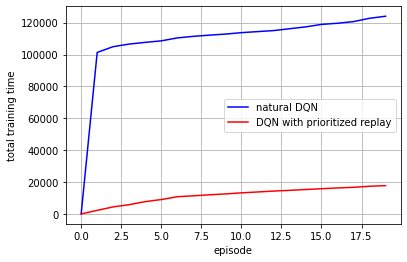

In [ ]:
plt.plot(his_natural[0, :], his_natural[1, :] - his_natural[1, 0], c='b', label='natural DQN')
plt.plot(his_prio[0, :], his_prio[1, :] - his_prio[1, 0], c='r', label='DQN with prioritized replay')
plt.legend(loc='best')
plt.ylabel('total training time')
plt.xlabel('episode')
plt.grid()
plt.show()